# $i$-RevNet and $i$-ResNet: Minor modifications to get an invertible neural network!

Our objective will be to design some neural networks that will be invertible.

In [2]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets,transforms

We first consider the model architecture given by: (it's a VGG-like model). We will define an initial layer without parameters that will simplify the construction of an invertible network later

In [3]:
import torch.nn as nn
#This is a function that will allow us to subsample the data into multiple input channels. It should be applied at the input. 
class psi(nn.Module):
    def __init__(self, block_size=4):
        super(psi, self).__init__()
        self.block_size = block_size
        self.block_size_sq = block_size*block_size

    def inverse(self, input):
        bl, bl_sq = self.block_size, self.block_size_sq
        bs, new_d, h, w = input.shape[0], input.shape[1] // bl_sq, input.shape[2], input.shape[3]
        return input.reshape(bs, bl, bl, new_d, h, w).permute(0, 3, 4, 1, 5, 2).reshape(bs, new_d, h * bl, w * bl)

    def forward(self, input):
        bl, bl_sq = self.block_size, self.block_size_sq
        bs, d, new_h, new_w = input.shape[0], input.shape[1], input.shape[2] // bl, input.shape[3] // bl
        return input.reshape(bs, d, new_h, bl, new_w, bl).permute(0, 3, 5, 1, 2, 4).reshape(bs, d * bl_sq, new_h, new_w)

In [4]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.inv_subsample = psi()
        self.conv1 = nn.Conv2d(16, 16, 7, padding=3)
        self.conv2 = nn.Conv2d(16, 16, 7,padding=3)
        self.conv3 = nn.Conv2d(16, 16, 7,padding=3)
        self.conv4 = nn.Conv2d(16, 16, 7,padding=3)
        self.fc = nn.Linear(28*28, 10)
    def forward(self, x):
        x = self.inv_subsample(x)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(-1, 28*28)
        x = self.fc(x)
        return x

The routines to load the data from the dataset are given by:

In [5]:
import torchvision
import torch
import torchvision.transforms as transforms

from torch.utils.data import Subset


dataset=torchvision.datasets.MNIST('./', download=True, transform=transforms.Compose([transforms.ToTensor()]), train=True)
train_indices = torch.arange(0,500)
train_dataset = Subset(dataset, train_indices)

dataset=torchvision.datasets.MNIST('./', download=True, transform=transforms.Compose([transforms.ToTensor()]), train=False)
test_indices = torch.arange(0,10000)
test_dataset = Subset(dataset, test_indices)


and the dataloader, which is actually used to depile the data is given by:

In [6]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64,
                                          shuffle=True, num_workers=0)

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=16,
                                          shuffle=False, num_workers=0)

1. Try to visualize some data that we will use along this lab session. The invertible downsampling, psi,  is needed to simplify the application of the n. It creates multiple channels with various subsamples of the original. For a randomly selected image visualize the image and apply psi() then visualization 2-3 of the channels.

torch.Size([64, 1, 28, 28])


torch.Size([28, 28])

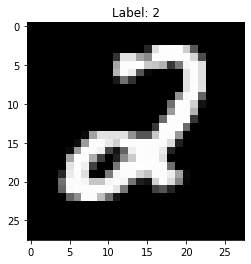

In [7]:
# Visualize a sample from MNIST
X_train_samples, y_train_samples = next(iter(trainloader))
plt.title(f'Label: {y_train_samples[0]}')
plt.imshow((X_train_samples[0].squeeze(0)).numpy(), cmap='gray');
print(X_train_samples.shape)
img=X_train_samples[0].squeeze(0)
# mynet=Net()
img.shape


torch.Size([64, 16, 7, 7])


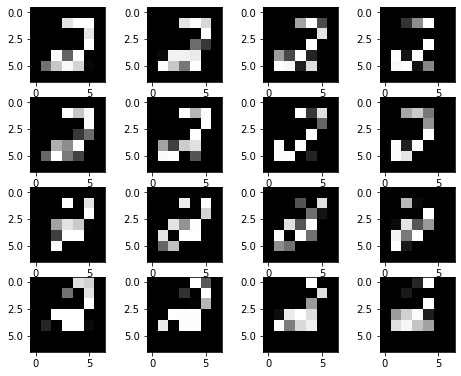

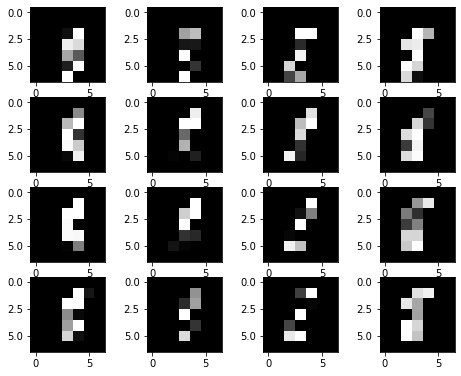

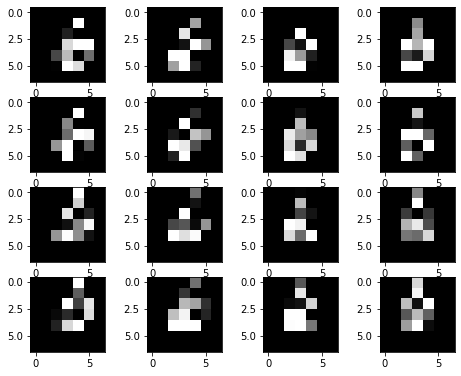

In [8]:
# out=mynet(X_train_samples)
inv_subsample = psi()
out=inv_subsample(X_train_samples)
print(out.shape)
w=10
h=10

dim_idx=0
for dim in out.detach().numpy():
    if dim_idx<3:
        fig=plt.figure(figsize=(8, 8))
        columns = 4
        rows = 5
        img_idx=1
        for channel in dim:
            img = np.random.randint(10, size=(h,w))
            fig.add_subplot(rows, columns, img_idx)
            plt.imshow(channel, cmap='gray')
            img_idx=img_idx+1
        plt.show()
        dim_idx=dim_idx+1




Use the following functions to train and test the model on this dataset. Train the neural network by running the cell.The NN should get around 80+-5%. You may adjust the number of epochs and learning rate if desired. 

In [67]:
import torch.optim as optim


def train(net, n_epoch=40, learning_rate=0.0422):
    
    loss = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    
    for epoch in range(n_epoch):  # loop over the dataset multiple times
        running_loss = []
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
#             print(inputs.shape)
            outputs = net(inputs)

            risk = loss(outputs, labels)
            risk.backward()
            optimizer.step()

            # print statistics
            running_loss.append(risk.detach().numpy())


    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            print(predicted)
            print(labels)

    print('Accuracy of the network on the 500 train images: %d %%' % (
        100 * correct / total))
    
    return net

def test(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on 10000 test images: %d %%' % (
        100 * correct / total))

net = Net()
net = train(net)
test(net)

torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([52, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([52, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([52, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([52, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 2

torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([52, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([52, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([52, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([52, 1, 28, 28])
tensor([2, 3, 1, 3, 2, 8, 6, 4, 0, 8, 7, 4, 0, 9, 7, 2, 1, 0, 7, 2, 1, 5, 1, 1,
        1, 0, 9, 5, 6, 1, 2, 5, 0, 8, 4, 1, 8, 4, 1, 1, 1, 3, 2, 2, 4, 0, 0, 4,
        5, 9, 8, 5, 0, 7, 1, 0, 4, 9, 9, 0, 7, 1, 2, 4])

# $i$-RevNets: NNs invertible by constructions
We will implement a simplified version of a fully invertible network the i-RevNet (https://openreview.net/pdf?id=HJsjkMb0Z).  



![picture](https://drive.google.com/uc?export=view&id=1L9bxNTqXkadfAhTiaw8Wll7cGtVYpZuM)



For a layer $j$, we split the features at layer $X_j=[x_j,\tilde x_j]$ where $\text{dim}(x_j)=n_j$ and $\text{dim}(\tilde x_j)=m_j$

Now let $F_j:\mathbb{R}^{n_j}\rightarrow \mathbb{R}^{m_{j+1}}$ represents a convolutional layer or series of convolutional layer + ReLU non-linearity.  We define each layer of the invertible architecture which takes input $[x_j, \tilde{x}_j]$  and outputs $[F_j(x_j)+\tilde{x}_j,x_j]$. The invertible $\Phi_F$ architecture using only $F=(F_1,...F_J)$ can be fully inverted in the end. 


3. Write a function that splits a tensor of size $(batch, chan, N, N)$ into two tensors of size $(batch, chan//2, N, N)$. So the final output should be $(2, batch, chan//2, N, N)$. Include the inverse operation which undoes this

In [91]:
a = torch.arange(64*1*28*28).reshape(64,1,28,28)
print(a.shape)
x=torch.split(a, 2,1)
# print(x[1])
z=torch.stack([x[0]], dim=2)
print(z.shape)
y=torch.cat((z[0], z[1]), 1)
y.shape


torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 1, 28, 28])


torch.Size([1, 2, 28, 28])

In [75]:
class SplitAlongChannels(nn.Module):
    def __init__(self):
        super(SplitAlongChannels, self).__init__()
    def forward(self,x):
        z=torch.split(x, 2,1)
        if len(z)>1 :
            return torch.stack([z[0], z[1]], dim=2)  
        else:
            return torch.stack([z[0]], dim=2)  
    def inverse(self,X):
        return torch.cat((X[0], X[1]), 1)

4. Write the corresponding invertible operation. This should include the forward pass which outputs $[F_j(x_j)+\tilde{x}_j,x_j]$ as defined above AND the inverse which is able to invert the effect of this layer.  

In [98]:
class InvertibleLayer(nn.Module):
    def __init__(self, kernel_size=7):
        super(InvertibleLayer, self).__init__()    
        self.conv = nn.Conv2d(1, 1, kernel_size,padding=kernel_size//2)
    def forward(self, X):
        print('InvertibleLayer X=',X.shape)
        print(type(X.shape))
        return [self.conv(X[0])+X[1],X[0]]
    def inverse(self, X):
         return [x[1],X[0]-self.conv(X[1])]

5. Write a class i-RevNet that consists in 4 layers, which is analog to *Net* (uses similarly sized convolutions). It should start with a splitting operation followed by 4 invertible layers. Note the final layer will apply a linear projection to 10 classes and is not invertible. Thus in the forward function include the ability to run the model up to the penultimate layer (the last invertible layer). 

In [101]:
import torch.nn.functional as F

# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.inv_subsample = psi()
#         self.conv1 = nn.Conv2d(16, 16, 7, padding=3)
#         self.conv2 = nn.Conv2d(16, 16, 7,padding=3)
#         self.conv3 = nn.Conv2d(16, 16, 7,padding=3)
#         self.conv4 = nn.Conv2d(16, 16, 7,padding=3)
#         self.fc = nn.Linear(28*28, 10)
#     def forward(self, x):
#         x = self.inv_subsample(x)
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         x = F.relu(self.conv3(x))
#         x = F.relu(self.conv4(x))
#         x = x.view(-1, 28*28)
#         x = self.fc(x)
#         return x

class iRevNet(nn.Module):
    def __init__(self):
        super(iRevNet, self).__init__()
        self.split=SplitAlongChannels()
        self.Invert=InvertibleLayer()
        self.fc = nn.Linear(28*28,10) # fill in the sizes
        
    def forward(self, x, classif=True):
        x=self.split(x)
        x=self.Invert(x)
        x=self.Invert(x)
        x=self.Invert(x)
        x=self.Invert(x)
        if classif:
            x = x.view(-1, 28*28)
            x = self.fc(x)
        return x
    
    def inverse(self, x):
        pass
                

6. Implement and run such architecture using the questions above. Compare the accuracies.

In [102]:
net = iRevNet()
net = train(net)
test(net)

torch.Size([64, 1, 28, 28])
InvertibleLayer X= torch.Size([64, 1, 1, 28, 28])
<class 'torch.Size'>


AttributeError: 'list' object has no attribute 'shape'

7. Validate on an example that your model is exactly invertible.

In [103]:
x = torch.randn(1,16,7,7)
y = net.forward(x,classif=False)
x_ = net.inverse(y)
print(torch.norm(x - x_)/torch.norm(x))

InvertibleLayer X= torch.Size([1, 2, 2, 7, 7])
<class 'torch.Size'>


RuntimeError: Given groups=1, weight of size [1, 1, 7, 7], expected input[2, 2, 7, 7] to have 1 channels, but got 2 channels instead

8. (Optional) For some invertible neural networks $\Phi$ and two images $x_0,x_1$, visualize for $0<t<1$ $x_t=\Phi^{-1}((1-t)\Phi x_0+t\Phi x_1)$. Note to visualize the images you will need to also invert the psi operation.